In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer


import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt


import warnings
warnings.filterwarnings('ignore')

2025-05-23 15:49:06.091379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748011746.107223  951628 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748011746.111771  951628 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748011746.125379  951628 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748011746.125395  951628 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748011746.125397  951628 computation_placer.cc:177] computation placer alr

In [2]:
df = pd.read_csv("BankRecords.csv")

In [3]:
df.head()

,ID,Age,Experience(Years),Income(Thousands's),Sort Code,Family,Credit Score,Education,Mortgage(Thousands's),Personal Loan,Securities Account,CD Account,Online Banking,CreditCard
0,1,25,1,49,91107,4,1.6,Diploma,0,No,Yes,No,No,No
1,2,45,19,34,90089,3,1.5,Diploma,0,No,Yes,No,No,No
2,3,39,15,11,94720,1,1.0,Diploma,0,No,No,No,No,No
3,4,35,9,100,94112,1,2.7,Degree,0,No,No,No,No,No
4,5,35,8,45,91330,4,1.0,Degree,0,No,No,No,No,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     5000 non-null   int64  
 1   Age                    5000 non-null   int64  
 2   Experience(Years)      5000 non-null   int64  
 3   Income(Thousands's)    5000 non-null   int64  
 4   Sort Code              5000 non-null   int64  
 5   Family                 5000 non-null   int64  
 6   Credit Score           5000 non-null   float64
 7   Education              5000 non-null   object 
 8   Mortgage(Thousands's)  5000 non-null   int64  
 9   Personal Loan          5000 non-null   object 
 10  Securities Account     5000 non-null   object 
 11  CD Account             5000 non-null   object 
 12  Online Banking         5000 non-null   object 
 13  CreditCard             5000 non-null   object 
dtypes: float64(1), int64(7), object(6)
memory usage: 547.0+ 

Before further exploation, I decided to rename the dataframe columns to make them easier to work with

In [5]:
df.columns = [
    'id', 'age', 'experience', 'income', 'sort_code', 'family',
    'credit_score', 'education', 'mortgage', 'personal_loan',
    'securities_account', 'cd_account', 'online_banking', 'credit_card'
]


In [6]:
df.describe()

,id,age,experience,income,sort_code,family,credit_score,mortgage
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937913,56.498800
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747666,101.713802
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,101.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,635.000000


The descriptive statistic above has showed something strange in the experience column, negative values.

It is not possible to have negative values in this column, so I decided to explore more by printing the unique values and displaying all the rows (52).

In [7]:
print(df['experience'].unique())
print("Number of row with negative experience:", len(df[df['experience'] < 0]))

[ 1 19 15  9  8 13 27 24 10 39  5 23 32 41 30 14 18 21 28 31 11 16 20 35
  6 25  7 12 26 37 17  2 36 29  3 22 -1 34  0 38 40 33  4 -2 42 -3 43]
Number of row with negative experience: 52


In [8]:
df[df['experience'] < 0]

,id,age,experience,income,sort_code,family,credit_score,education,mortgage,personal_loan,securities_account,cd_account,online_banking,credit_card
89,90,25,-1,113,94303,4,2.300000,Masters,0,No,No,No,No,Yes
226,227,24,-1,39,94085,2,1.700000,Degree,0,No,No,No,No,No
315,316,24,-2,51,90630,3,0.300000,Masters,0,No,No,No,Yes,No
451,452,28,-2,48,94132,2,1.750000,Masters,89,No,No,No,Yes,No
524,525,24,-1,75,93014,4,0.200000,Diploma,0,No,No,No,Yes,No
536,537,25,-1,43,92173,3,2.400000,Degree,176,No,No,No,Yes,No
540,541,25,-1,109,94010,4,2.300000,Masters,314,No,No,No,Yes,No
576,577,25,-1,48,92870,3,0.300000,Masters,0,No,No,No,No,Yes
583,584,24,-1,38,95045,2,1.700000,Degree,0,No,No,No,Yes,No
597,598,24,-2,125,92835,2,7.200000,Diploma,0,No,Yes,No,No,Yes


After inspection, most of the persons with a negative experience are young, aged between 23 and 29. A reasonable age for someone finishing college with a range of 1-3 years of experience.

Since the other columns were coherent all together and nothing looked strange, this increases the possibility of the - sign being added by mistake so I decided to reverse the negative values to positive.

In [9]:
# Flip all negative experience values to positive
df['experience'] = df['experience'].apply(lambda x: -x if x < 0 else x)

In [10]:
df['bank_code'] = df['sort_code'].astype(str).str[:2]
df['bank_code'] = df['bank_code'].astype(int)

In [11]:
df.head()

,id,age,experience,income,sort_code,family,credit_score,education,mortgage,personal_loan,securities_account,cd_account,online_banking,credit_card,bank_code
0,1,25,1,49,91107,4,1.6,Diploma,0,No,Yes,No,No,No,91
1,2,45,19,34,90089,3,1.5,Diploma,0,No,Yes,No,No,No,90
2,3,39,15,11,94720,1,1.0,Diploma,0,No,No,No,No,No,94
3,4,35,9,100,94112,1,2.7,Degree,0,No,No,No,No,No,94
4,5,35,8,45,91330,4,1.0,Degree,0,No,No,No,No,Yes,91


In [12]:
correlation = df['bank_code'].corr(df["income"], method='pearson')
print("Pearson correlation:", correlation)

Pearson correlation: -0.028900023071394925


Before proceeding to medelling, I decided to remove 2 columns:
- The first is the ID column, as it's random and not relevant to the predict income.
- The second is the sort code, knowing your bank/branch wouldn't help much in predcting income. Even though customers with similar income range may prefer certain banks which may include some influence, but as shown above there is no relationship between banks and incomes so I will get rid of it.

In [13]:
df = df.drop(columns=['id','sort_code','bank_code'])

We also have a strong correlation between age and experience which will cause some redundancy and noise in our prediction, that is why I decided 

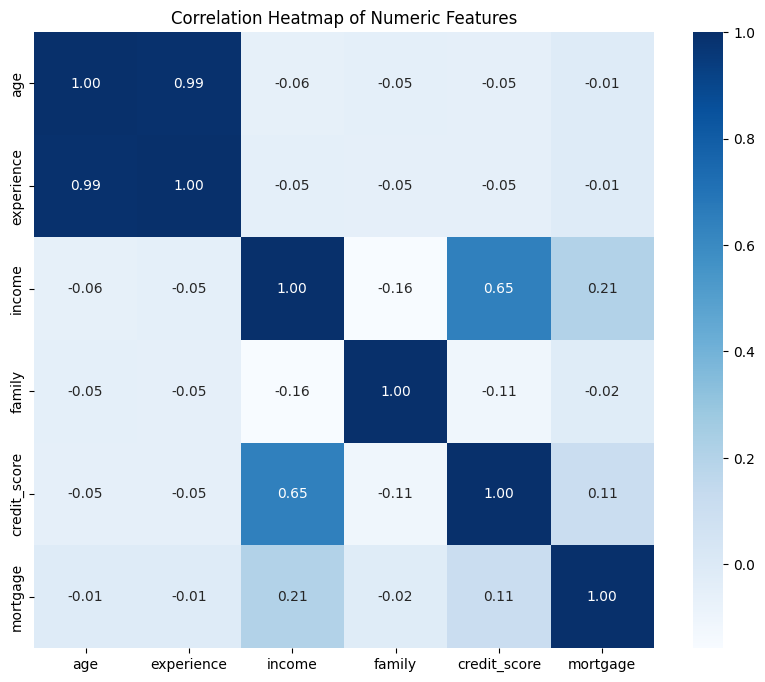

In [14]:
# Extracting numeric values only
df_numeric = df.select_dtypes(include=['int64', 'float64'])


corr_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

We see above that there is a strong correlation between age and experience. Given that experience had negative values earlier on, I decided to drop it as it's redundant with age, and may cause some unnecessary noise to the model.

In [15]:
df = df.drop(columns='experience')

Now we take a look at the categorical columns, we see that education had 3 different categories and all the other columns were binary (Yes or No), so we need to encode them.

I have used boolean operators (True = Yes, No = False) for the binary columns and I used one-hot encoding for the education.

In [16]:
# binary columns' names
binary_cols = ['personal_loan', 'securities_account', 'cd_account', 'online_banking', 'credit_card']

# Mapping the values to boolean
for col in binary_cols:
    df[col] = df[col].map({'Yes': True, 'No': False})


In [17]:
# One-hot encoding for education
df_clean = pd.get_dummies(df, columns=['education'])
df_clean

,age,income,family,credit_score,mortgage,personal_loan,securities_account,cd_account,online_banking,credit_card,education_Degree,education_Diploma,education_Masters
0,25,49,4,1.6,0,False,True,False,False,False,False,True,False
1,45,34,3,1.5,0,False,True,False,False,False,False,True,False
2,39,11,1,1.0,0,False,False,False,False,False,False,True,False
3,35,100,1,2.7,0,False,False,False,False,False,True,False,False
4,35,45,4,1.0,0,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,40,1,1.9,0,False,False,False,True,False,False,False,True
4996,30,15,4,0.4,85,False,False,False,True,False,False,True,False
4997,63,24,2,0.3,0,False,False,False,False,False,False,False,True
4998,65,49,3,0.5,0,False,False,False,True,False,True,False,False


In [18]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 5000 non-null   int64  
 1   income              5000 non-null   int64  
 2   family              5000 non-null   int64  
 3   credit_score        5000 non-null   float64
 4   mortgage            5000 non-null   int64  
 5   personal_loan       5000 non-null   bool   
 6   securities_account  5000 non-null   bool   
 7   cd_account          5000 non-null   bool   
 8   online_banking      5000 non-null   bool   
 9   credit_card         5000 non-null   bool   
 10  education_Degree    5000 non-null   bool   
 11  education_Diploma   5000 non-null   bool   
 12  education_Masters   5000 non-null   bool   
dtypes: bool(8), float64(1), int64(4)
memory usage: 234.5 KB


As we can see below, the values are in different ranges so we would need to scale them. The columns are not normally distributed and there are some skewness and We are having outliers especially for mortgage column so we will be using robust scaler as it is performs better against outliers.

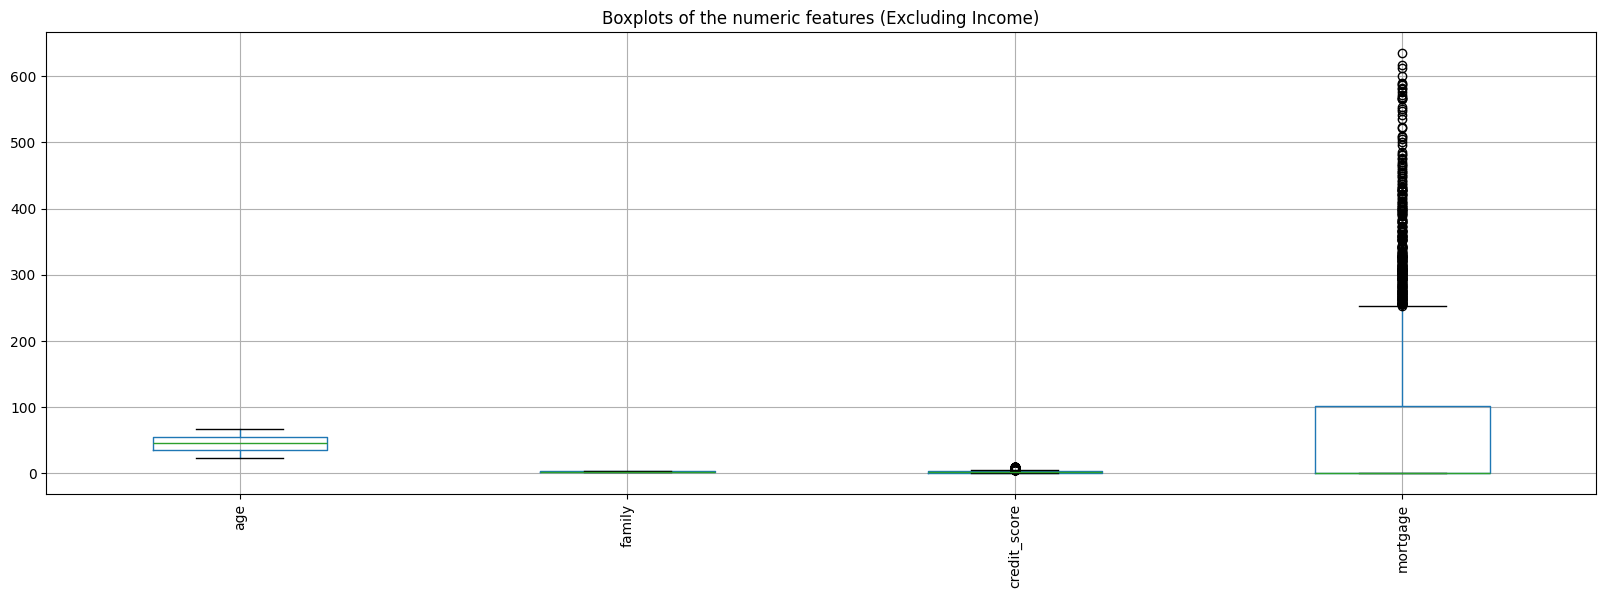

In [19]:
df_numeric = df_clean.select_dtypes(include=['int64', 'float64']).drop(columns='income')

## Boxplot of all features
df_numeric.boxplot(figsize=(20, 6), rot=90)
plt.title('Boxplots of the numeric features (Excluding Income)')
plt.show()

In [20]:
scaler = RobustScaler()
columns= df_numeric.columns
df_numeric = scaler.fit_transform(df_numeric)
df_numeric = pd.DataFrame(df_numeric, columns=columns)

This is how the data became after scaling, This is shown for visualisation purposes and I will be scaling after splitting the data to avoid data leakage which occurs when information that would not be available at prediction time is used when building the model (scikit-learn, 2025).


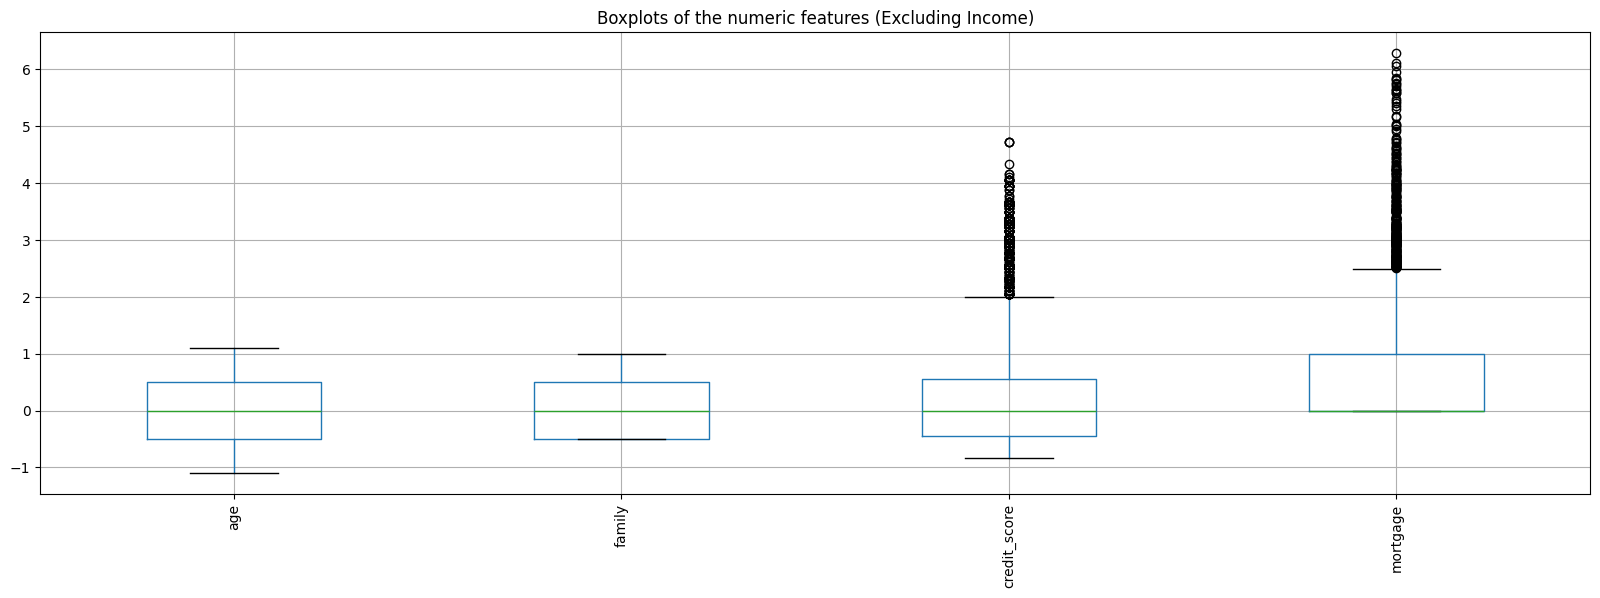

In [21]:
df_numeric.boxplot(figsize=(20, 6), rot=90)
plt.title('Boxplots of the numeric features (Excluding Income)')
plt.show()

## Data splitting

In [22]:
X = df_clean.drop(columns='income')
y = df_clean['income']

In [23]:
# Splitting data into training and testing sets (80/20)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state = 11)

In [24]:
# numerical columns list
num_cols = df_numeric.columns.to_list()

preprocessor = ColumnTransformer([
    ('num', scaler, num_cols)
], remainder= 'passthrough' ) # We only scale the numerical values, categorical variables are already encoded and they shouldn't be scaled


X_train = preprocessor.fit_transform(X_train)
X_test= preprocessor.transform(X_test)



## Base Neural network

In [25]:
model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    Dense(16, activation = 'relu'), # First hidden layer with relu activation
    Dense(8, activation = 'relu'), # Second hidden layer
    Dense(1) # Output layer
])
# Compile the model using Adam optimizer
model.compile(optimizer = 'adam',loss='mse', metrics=['mae'])
# Training the model for 100 epochs, batch size of 64 and 20% validation split
model.fit(X_train, y_train,
          validation_split=0.2,
          epochs=100,
          batch_size=64,
          verbose=1)        



I0000 00:00:1748007539.251966  929614 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/100


I0000 00:00:1748007538.829699  929702 service.cc:152] XLA service 0x7f9004005390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748007538.829735  929702 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-05-23 14:38:58.849384: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748007538.964407  929702 cuda_dnn.cc:529] Loaded cuDNN version 90300


34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7474.5405 - mae: 72.9886

I0000 00:00:1748007539.674153  929702 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7518.4795 - mae: 73.2433 - val_loss: 7712.3882 - val_mae: 75.0990
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7293.0854 - mae: 72.3232 - val_loss: 7515.7827 - val_mae: 73.9661
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7412.9980 - mae: 72.4903 - val_loss: 7144.1968 - val_mae: 71.7428
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6867.7388 - mae: 69.3545 - val_loss: 6449.5850 - val_mae: 67.3394
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5952.8652 - mae: 63.5178 - val_loss: 5377.5942 - val_mae: 60.0198
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5142.0708 - mae: 57.1365 - val_loss: 4064.3547 - val_mae: 50.1584
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3688.9907 - mae: 46.2465 - val_loss: 2861.7961 - val_mae: 40.2288
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2542.4172 - mae: 37.1994 - val_loss: 2031.5223 - val_mae: 33.4235
Epoch 9/100

In [26]:
model.save("base_nn.keras")

As a base, I have implemented a simple neural network architectue with 2 dense layers (16 and 8 neurons respectively) and 1 output layer for the regression which will predict the target variable "income". 

This architecture is very simple and it is meant to have an idea where does a basic neural network stand in terms of performance.

## Hyperparameter tuning

In [27]:
def build_model(hp):
    # defined number of neurons within this range
    values=[16,32,64,128]
    
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  
    model.add(Dense(
        units=hp.Choice('units_1', values=values),
        activation='relu', # relu activation
    ))
    # dropout rate value ranging between 0 (none) and 0.4
    model.add(Dropout(rate=hp.Float('dropout_1', 0.0, 0.4, step=0.1)))

    # add a second layer
    model.add(Dense(
        units=hp.Choice('units_2', values=values),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_2', 0.0, 0.4, step=0.1)))

    model.add(Dense(1))  #  output layer

    model.compile(     # Compile the model with Adam optimizer and mean squared error loss function
        optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mean_absolute_error']  
    )
    return model


In [28]:
# Using random search for hyperparameters tuning
# https://keras.io/keras_tuner/api/tuners/random/

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=300, # 300 combinations to go through
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='ML_CA2',
    overwrite = False
)


Reloading Tuner from keras_tuner_dir/ML_CA2/tuner0.json


In [29]:
tuner.search(X_train, y_train,
             epochs=50, # each combination will be trained for 50 epochs
             validation_split=0.2, # validation split of 20$ (of the training set)
             callbacks=[EarlyStopping(monitor='val_loss', patience=10)]) # we will stop early if loss doesn't decrease for more than 10 epochs


In [30]:
# Getting the best hyperparameters found
best_hyperparams = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
print(best_hyperparams.values)

Best hyperparameters:
{'units_1': 32, 'dropout_1': 0.0, 'units_2': 16, 'dropout_2': 0.1, 'learning_rate': 0.01}


In [31]:
# Rebuilding model with those hyperparameters
final_model = build_model(best_hyperparams)

# Defining callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, min_lr=1e-6, verbose=1) # We reduce the learning rate if the model stagnates

# Retraining on full training set with same settings 
final_model.fit(X_train, y_train,
                validation_split=0.2,
                epochs=150,
                batch_size=64,
                callbacks=[reduce_lr],
                verbose=1)



Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6260.3188 - mean_absolute_error: 63.6321 - val_loss: 1301.7097 - val_mean_absolute_error: 28.2147 - learning_rate: 0.0100
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1221.6207 - mean_absolute_error: 26.4728 - val_loss: 976.5514 - val_mean_absolute_error: 25.3131 - learning_rate: 0.0100
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1010.8242 - mean_absolute_error: 25.0373 - val_loss: 973.3161 - val_mean_absolute_error: 24.4412 - learning_rate: 0.0100
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1009.7355 - mean_absolute_error: 24.8383 - val_loss: 932.3884 - val_mean_absolute_error: 24.1465 - learning_rate: 0.0100
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1028.1088 - mean_absolute_error: 25.0530 - val_loss: 892.5798 - val_mean_absolute_error: 24.0797 - learning_rate: 0.0100
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ -2s -39103us/step - loss: 972.8749 - mean_absolute_error: 2

In [32]:
final_model.save("final_nn.keras")

For the hyperparameter tuning, I have defined a search space that includes a total of 1200 combinations, which balances some flexibility while remaining computationally efficient.
- Neurons per layer (units_1, units_2): The number of neurons for each layer was selecting from [16, 32, 64, 128] which covers a good range of models from the simple to slightly more complex, without being unnecessarily complex based on the relatively small dataset size.
- Dropout: Dropout ranges from 0 (no dropout) to 0.4 (in 0.1 steps) to add a regularization aspect to the model especially because I am training it for a high number of epochs which may cause overfitting. 
- Activation: Dense layers used the ReLu activation which allows non-linearity and efficient gradient propagation. The final layer uses no activation since we are predicting a continuous value (Brownlee, 2019). 
- Learning rate: Learning rate was either 0.01, 0.001 or 0.0001. These values are standard default for Adam optimizer, which were accompanied with reducing learning (ReduceLROnPlateau) when the model stagnates (IBM, 2024).
- Early Stopping: Early stopping was also used in the random search, where we wait for 10 epochs with no improvement and then exit. This will save a massive amount of time and avoid training bad performing models (Cyborg, 2024).

In order to perform the hyperparameter tuning, I used RandomSearch from Keras Tuner, which will explore 25% of the possible 1200 combinations. Ideally I wanted to perform Grid search with cross-validation, but it was causing a lot of issues with the current hardware setup. Each model was trained for 50 epochs, and the best performing model -based on mean square error- was trained for 150 epochs with a batch size of 64.

## Standard Random Forest Regressor

In [25]:
# Redefining the sets Random Forest doesn't require scaling
X_train_rf, X_test_rf, y_train_rf, y_test_rf= train_test_split(X, y, test_size = 0.2, random_state = 11)

In [26]:
rf = RandomForestRegressor(random_state=11)
# Train the model
rf.fit(X_train_rf, y_train_rf)

RandomForestRegressor(random_state=11)

# Evaluation


## base neural network performance

In [27]:
# Loading the base model
model = load_model("base_nn.keras")

# Evaluate the base model on the test set
base_nn_predictions = model.predict(X_test)

# Calculate Mean Squared Error
base_nn_mse = mean_squared_error(y_test, base_nn_predictions)

# Calculate Mean Absolute Error
base_nn_mae = mean_absolute_error(y_test, base_nn_predictions)

# Calculate R-squared
base_nn_r2 = r2_score(y_test, base_nn_predictions)

# Print the evaluation metrics
print("Base Neural Network Model Results")
print(f"Mean Squared Error: {base_nn_mse:.2f}")
print(f"Mean Absolute Error: {base_nn_mae:.2f}")
print(f"R-squared: {base_nn_r2:.2f}")

I0000 00:00:1748011788.487280  951628 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1748011789.972015  951738 service.cc:152] XLA service 0x7f264c0052d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748011789.972109  951738 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-05-23 15:49:49.994491: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748011790.031523  951738 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/32 ━━━━━━━━━━━━━━━━━━━━ 17s 574ms/step

I0000 00:00:1748011790.470930  951738 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Base Neural Network Model Results
Mean Squared Error: 799.31
Mean Absolute Error: 22.23
R-squared: 0.61


## tuned neural network performance


In [28]:
# Loading the final model 
final_model = load_model("final_nn.keras")
# Evaluate the model on the test set
final_nn_predictions = final_model.predict(X_test)

# Calculate Mean Squared Error
final_nn_mse = mean_squared_error(y_test, final_nn_predictions)

# Calculate Mean Absolute Error
final_nn_mae = mean_absolute_error(y_test, final_nn_predictions)

# Calculate R-squared
final_nn_r2 = r2_score(y_test, final_nn_predictions)

# Print the evaluation metrics
print("Custom Neural Network Model Results")
print(f"Mean Squared Error: {final_nn_mse:.2f}")
print(f"Mean Absolute Error: {final_nn_mae:.2f}")
print(f"R-squared: {final_nn_r2:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Custom Neural Network Model Results
Mean Squared Error: 732.52
Mean Absolute Error: 20.86
R-squared: 0.64


## Standard Random Forest Performance

In [29]:
# Evaluate the rf model on the test set
rf_predictions = rf.predict(X_test_rf)

# Calculate Mean Squared Error
rf_mse = mean_squared_error(y_test_rf, rf_predictions)

# Calculate Mean Absolute Error
rf_mae = mean_absolute_error(y_test_rf, rf_predictions)

# Calculate R-squared
rf_r2 = r2_score(y_test_rf, rf_predictions)

print(f'Random Forest MSE: {rf_mse:.2f}')
print(f'Random Forest MAE: {rf_mae:.2f}')
print(f'Random Forest R2 Score: {rf_r2:.2f}')


Random Forest MSE: 395.12
Random Forest MAE: 13.70
Random Forest R2 Score: 0.80


In [30]:
model_metrics = {
    'BaseNN': [base_nn_mse, base_nn_mae, base_nn_r2],
    'Final NN': [final_nn_mse, final_nn_mae, final_nn_r2],
    'Random Forest': [rf_mse, rf_mae, rf_r2]
}

metrics_df = (
    pd.DataFrame.from_dict(
        model_metrics,
        orient="index",
        columns=["MSE", "MAE", "R2"]
    )
    .round(2)                           # round values 2 decimals
    .sort_values("R2", ascending=False) # Models are ranked based on the r2 score
)

metrics_df


,MSE,MAE,R2
Random Forest,395.12,13.70,0.80
Final NN,732.52,20.86,0.64
BaseNN,799.31,22.23,0.61


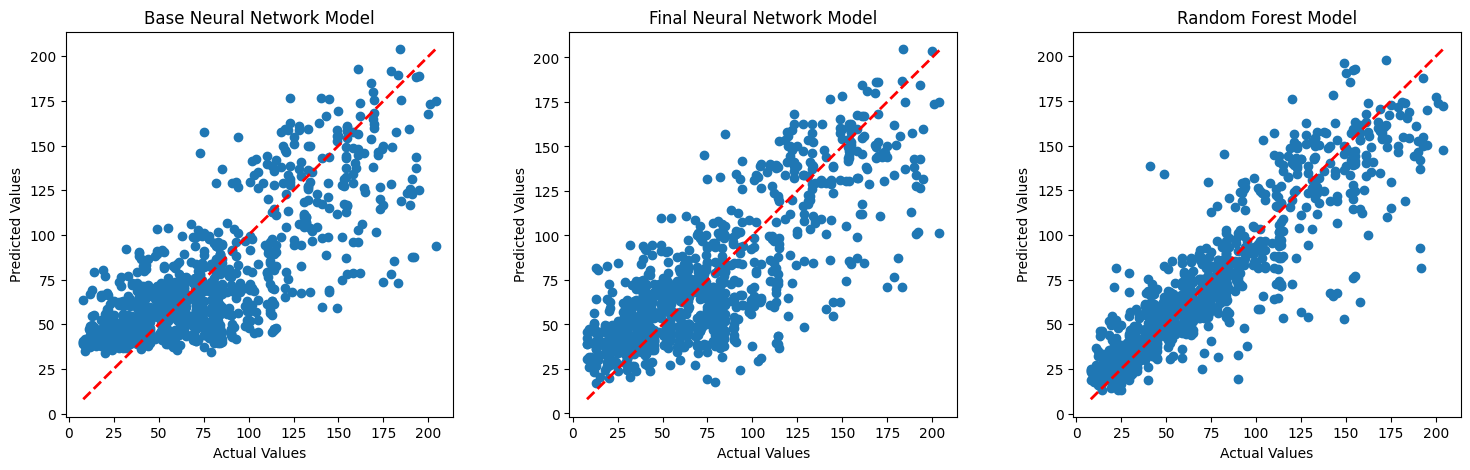

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Base Neural Network Model
axes[0].scatter(y_test, base_nn_predictions)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_title('Base Neural Network Model')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')

# Final Neural Network Model
axes[1].scatter(y_test, final_nn_predictions)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_title('Final Neural Network Model')
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')

# Random Forest Model
axes[2].scatter(y_test, rf_predictions)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_title('Random Forest Model')
axes[2].set_xlabel('Actual Values')
axes[2].set_ylabel('Predicted Values')

plt.subplots_adjust(wspace=0.3)

# Display the plot
plt.show()

In [32]:
importances = rf.feature_importances_
feature_names = X.columns

In [33]:
importance_df = (
    pd.DataFrame({"Feature": feature_names,
                  "Importance": importances})
      .sort_values("Importance", ascending=False)
      .reset_index(drop=True)
)
importance_df

,Feature,Importance
0,credit_score,0.546476
1,age,0.130070
2,personal_loan,0.115186
3,mortgage,0.077866
4,family,0.063164
5,education_Diploma,0.024833
6,online_banking,0.012422
7,credit_card,0.010257
8,education_Masters,0.006369
9,education_Degree,0.005400


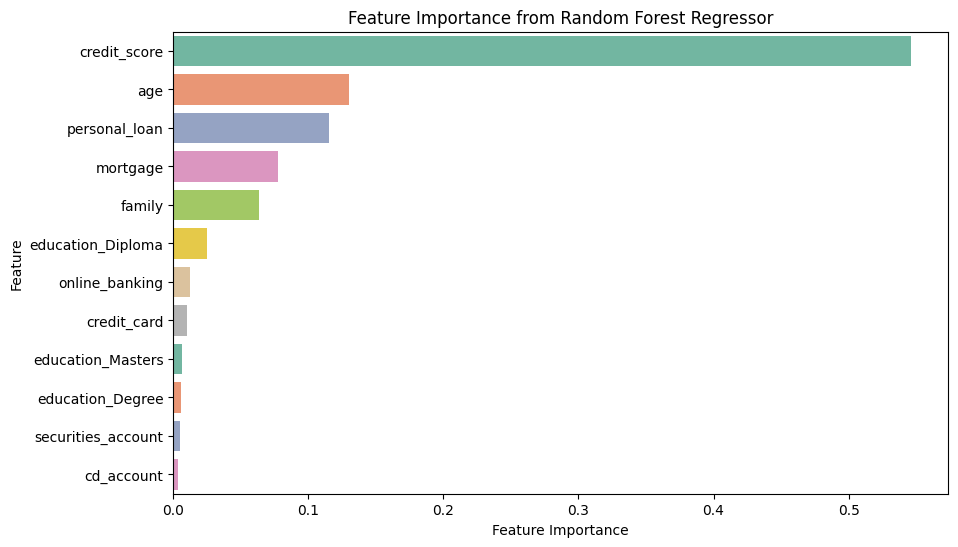

In [35]:
# Feature Importance Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df,  palette='Set2') 
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Regressor')
plt.show()


# References:


- scikit-learn. (2025). 10. Common pitfalls and recommended practices. [online] Available at: https://scikit-learn.org/stable/common_pitfalls.html#how-to-avoid-data-leakage.
- Brownlee, J. (2019). A Gentle Introduction to the Rectified Linear Unit (ReLU) for Deep Learning Neural Networks. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/.
- IBM (2024). Learning rate. [online] Ibm.com. Available at: https://www.ibm.com/think/topics/learning-rate.
- Cyborg (2024). What is Early Stopping in Deep Learning? - Cyborg - Medium. [online] Medium. Available at: https://cyborgcodes.medium.com/what-is-early-stopping-in-deep-learning-eeb1e710a3cf.